# Retinal AD
This notebook contains code for predicting brain pathology and cognitive measures from measures taken from retina. The original data has been modified to remove invalid entries (e.g., dates in measures).
The code investigates two sets of questions:
- Can we predict brain pathologies from retinal measures?
- Can we predict disease status (normal control (NC), mild cognitive impairment (MCI), or Alzheimer's disease (AD))?

## Preamble
Preparing dependencies and verifying that the data is correct.

In [1]:
import sklearn as sk
import pandas as pd
import seaborn as sns
import retinad
import retinad.preprocessing
import os
from importlib import reload
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
import hashlib
import retinad.analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from collections import defaultdict as dd
import matplotlib.patches as mpatches
from datetime import datetime
from matplotlib.patches import Rectangle
data_file = "data/Cp multivariable file-12-23-2024_added retinal atrophy data.xlsx"
original_file = "data/Cp multivariable file-12-23-2024_added retinal atrophy data_unmodified.xlsx"

date_str = datetime.now().strftime("%Y_%m_%d")
r_dir = f"results_{date_str}/"

if not os.path.exists(r_dir):
    os.mkdir(r_dir)
if not os.path.exists(data_file):
    raise ValueError("The data file does not exist.")

In [2]:
# Check that the file is consistent with the one used for developing the notebook.
s = hashlib.sha3_256()
with open(data_file, "rb") as f:
    chunk = f.read(1024)
    s.update(chunk)

if s.hexdigest() != "cf3e88a14112b8c12e867a51c14a5c086f35f97ae943b1826b42240f37ccaa7d":
    raise ValueError("The data file is not consistent with the data that was originally analyzed. Results may differ.")

if os.path.exists(original_file):
    s = hashlib.sha3_256()
    with open(original_file, "rb") as f:
        chunk = f.read(1024)
        s.update(chunk)
    if s.hexdigest() != "56fefb514fe281b256ba98f009a04e3b2d7da45d55fb8a1128abaecd2f1986b1":
        raise ValueError("The data file is not consistent with the data that was originally analyzed. Results may differ.")

## Load data

In [3]:
data = pd.read_excel(data_file, skiprows=2, index_col="Pt ID (LAB)")
retinal_features = [c for c in data.columns if "retinal" in c.lower()]
retinal_features += list(data.columns[-2:])

brain_pathology_features = [c for c in data.columns if "brain" in c.lower()]
brain_pathology_features += ["Braak Stage", "ABC average", "CAA score"]
cognition_features = ["CDR Global [score]", "MMSE [score]", "MOCA"]
# for c in data.columns:
#     print(f"{c}: {data[c].dtype}")

retinad.preprocessing.extract_diagnosis(data)
train, test = train_test_split(data, stratify=data["diagnosis"], random_state=0, train_size=0.8)
train, valid = train_test_split(train, stratify=train["diagnosis"], random_state=0, train_size=0.7)
all_train = pd.concat([train, valid])

Check label distribution across training and testing datasets.

In [4]:
test.value_counts("diagnosis")

diagnosis
AD     7
NC     4
MCI    3
Name: count, dtype: int64

In [5]:
all_train.value_counts("diagnosis")

diagnosis
AD     27
NC     17
MCI    12
Name: count, dtype: int64

In [6]:
# Sanity check
assert len(set(retinal_features).intersection(set(brain_pathology_features))) == 0
assert len(set(retinal_features).intersection(set(cognition_features))) == 0
assert len(set(cognition_features).intersection(set(brain_pathology_features))) == 0

## Pathology and Cognition prediction
The section prepares models (RandomForest) that use up to two features to predict brain pathologies and cognition measures.

In [7]:
del brain_pathology_features[brain_pathology_features.index('Brain Cp (% area)')]

In [8]:
data.columns

Index(['USC NC', 'ID #', 'UDS ID', 'APOE genotype', 'APOE4 presence',
       'CDR Global [score]', 'MMSE [score]', 'MOCA',
       'A-Brain Aβ plq total [severity score]',
       'T-Brain NFT total  [severity score]',
       'N-Brain Atrophy [severity score]', 'Braak Stage', 'ABC average',
       'Brain Gliosis (severity score)', 'CAA score', 'Brain Cp (% area)',
       'Retinal Cp (% area)', 'Retinal Aβ42 total (12F4, %Area)',
       'Retinal AβOi total  μm2x103', 'Retinal GFAP1 % area Bhakta',
       'Retinal IBA1 % area Bhakta', 'Retinal Atrophy (severity score)',
       'Retinal Vimentin total area/1000 (μm2x103)',
       'Retinal Nissl  (% area) ONL+INL+GCL', 'Retinal MC-1 tau (% area)',
       'Retinal Oligo-tau T22 (% area)', 'Retinal pS396 (% area)',
       'Retinal PHF-1 (% area)', 'Retinal NLRP3 (% area)',
       'Retinal Caspase-1 (% area)', 'Retinal ASC (% area)',
       'Retinal Cleaved Caspase-3 (% area)', 'Retinal NGSDMD (% area)',
       'Retinal vAβ40 all Vessels ( 11A5

In [9]:
model_parameters = {"random_state": 0, "n_estimators": 80}
targets_to_keep = set()

reference_features = ["Retinal Cp (% area)", "Retinal NLRP3 (% area)", "Retinal Cleaved Caspase-3 (% area)", "Retinal Aβ42 total (12F4, %Area)"]
combined_features = []
combined_features.append([])
combined_features.append(["Retinal Aβ42 total (12F4, %Area)"])
combined_features.append(['Retinal IBA1 % area Bhakta', 'Retinal Vimentin total area/1000 (μm2x103)', 'Retinal GFAP1 % area Bhakta'])
combined_features.append(["Retinal Atrophy (severity score)"])
short_name = {"Retinal Cp (% area)": "Ret Cp",
              "Retinal NLRP3 (% area)": "Ret NLRP3",
              "Retinal Cleaved Caspase-3 (% area)": "CCaspase3",
              "Retinal Aβ42 total (12F4, %Area)": "Ret Aβ42",
              'Retinal IBA1 % area Bhakta': "Ret IBA1",
              'Retinal Vimentin total area/1000 (μm2x103)': "Ret Vimentin",
              'Retinal GFAP1 % area Bhakta': "Ret GFAP1",
              "Retinal Atrophy (severity score)": "Ret Atrophy"}

short_name = {"Retinal Cp (% area)": "Cp",
              "Retinal NLRP3 (% area)": "NLRP3",
              "Retinal Cleaved Caspase-3 (% area)": "CCaspase3",
              "Retinal Aβ42 total (12F4, %Area)": "Aβ42",
              'Retinal IBA1 % area Bhakta': "IBA1",
              'Retinal Vimentin total area/1000 (μm2x103)': "Vimentin",
              'Retinal GFAP1 % area Bhakta': "GFAP1",
              "Retinal Atrophy (severity score)": "Atrophy"}

This section selects a main feature, combines it with another set, fits a random forest regressor, and produces boxplots to show the distribution of model performance in a 5-repeated 2-fold cross-validation.

/home/lex/projects/retinal_ad/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/lex/projects/retinal_ad/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/lex/projects/retinal_ad/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/lex/projects/retinal_ad/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/lex/projects/retinal_ad/venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated clas

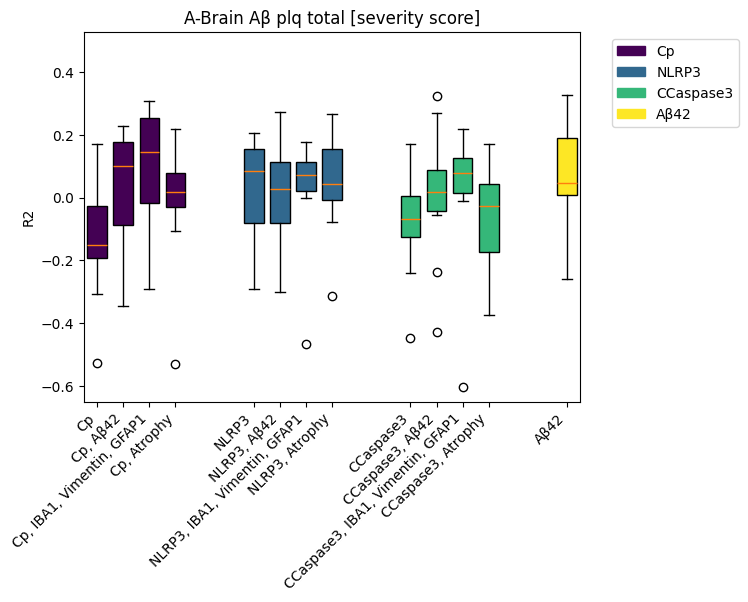

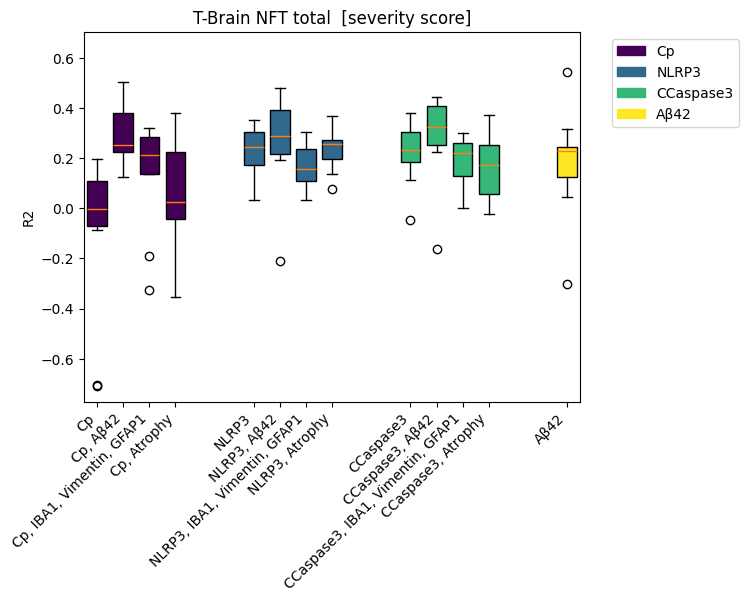

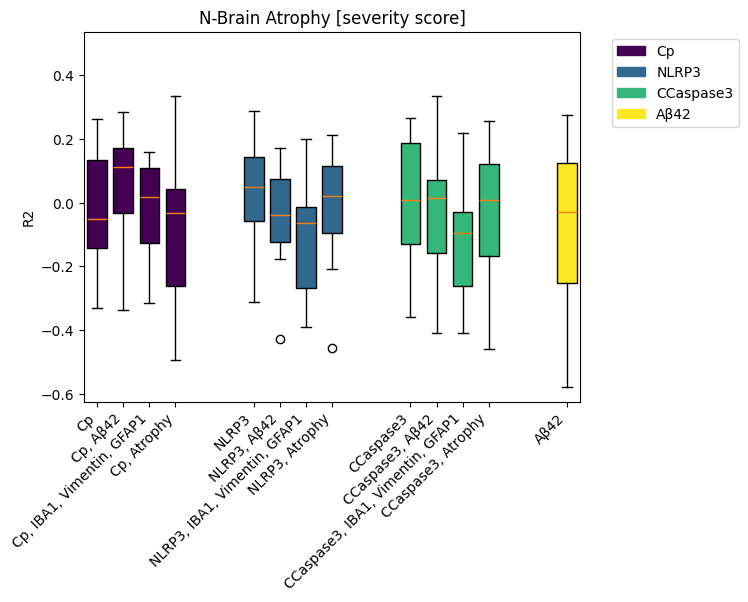

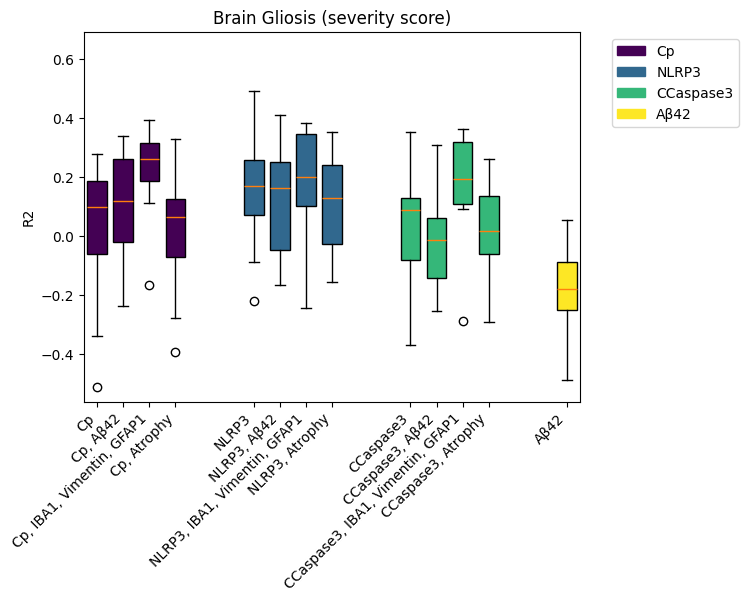

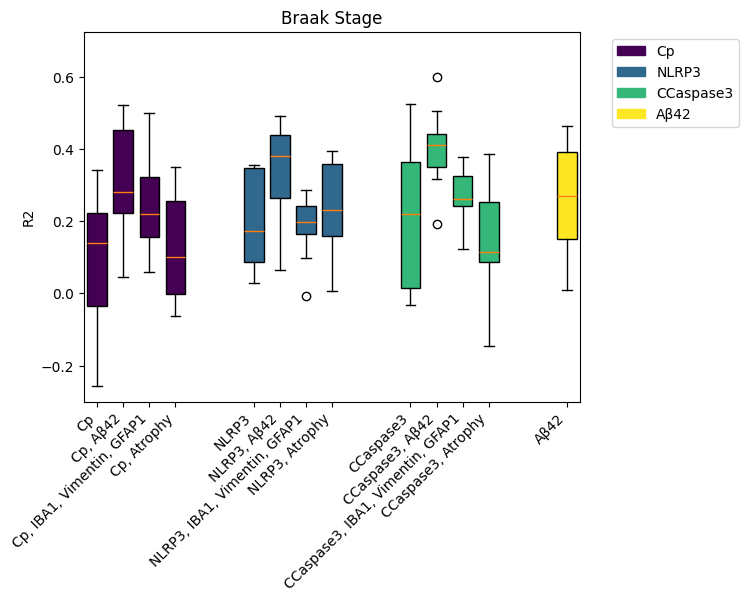

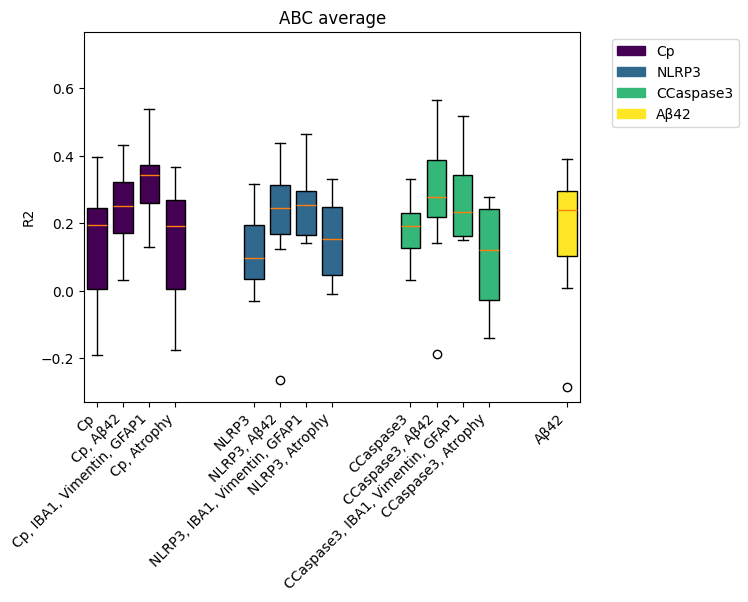

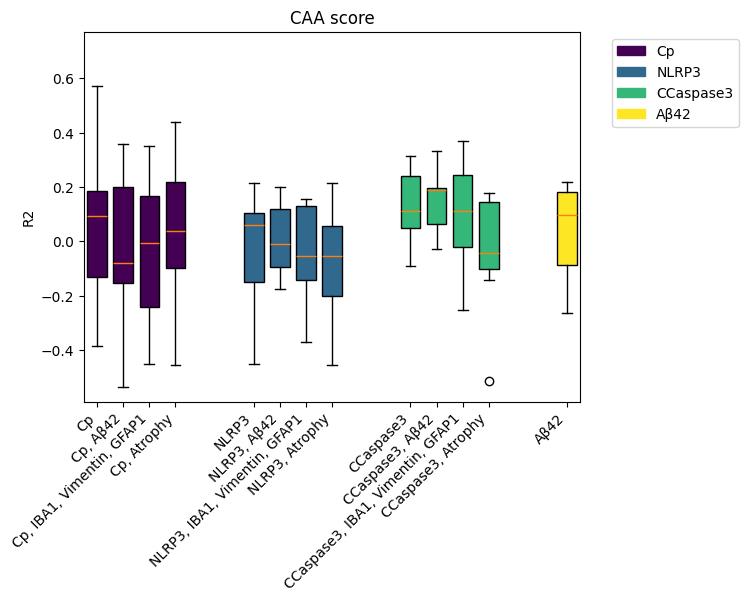

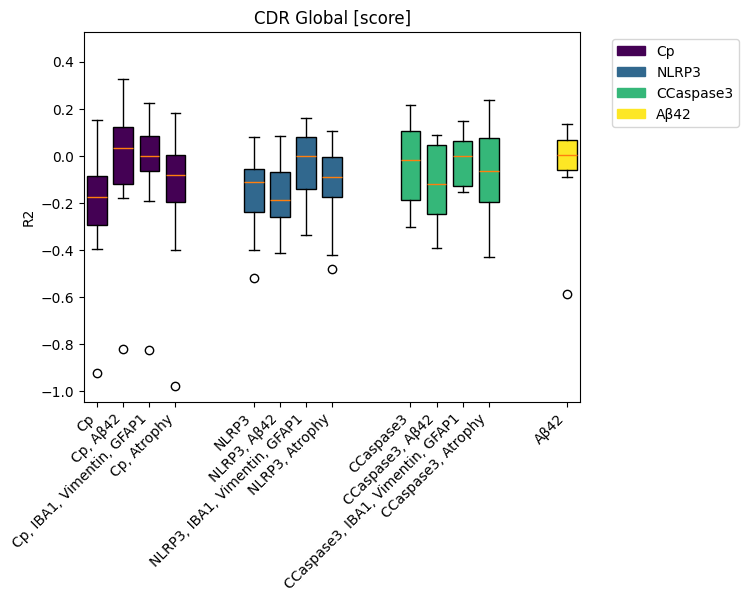

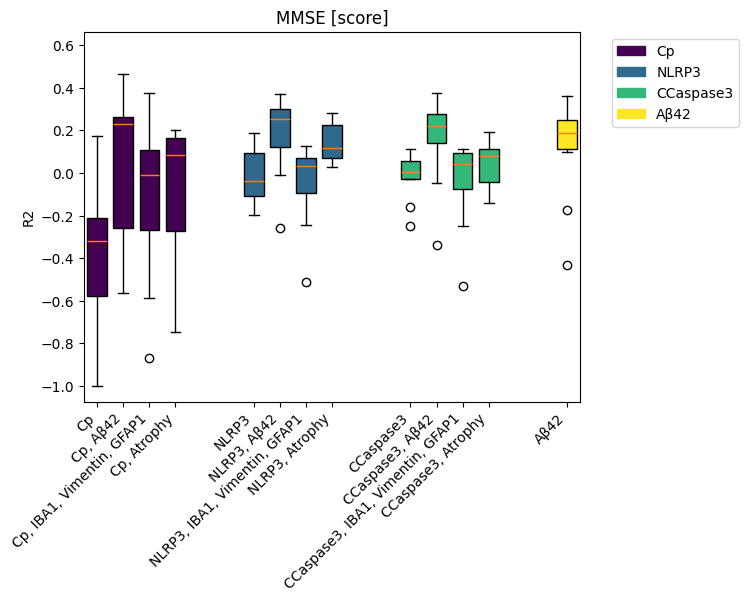

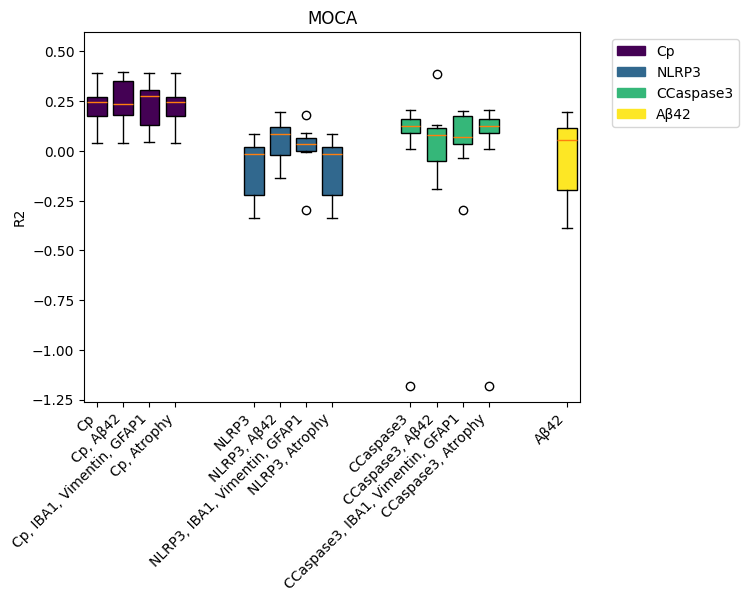

In [10]:
f = open(f"{r_dir}/model_r2_scores.txt", "w")
for bp in brain_pathology_features + cognition_features:
    f.write(f"----- Predicting {bp} -----\n")
    p_list = []
    label_list = []
    p_dict = dd(list)
    p_dict_labels = dd(list)
    for i, ref_feat in enumerate(reference_features):
        for j, c_feat in enumerate(combined_features):
            if ref_feat == "Retinal Aβ42 total (12F4, %Area)":
                if j == 0:
                    feats = [ref_feat]
                else:
                    continue
            else:
                feats = [ref_feat] + c_feat
            p = retinad.analysis.cv_eval2(RandomForestRegressor, model_parameters, all_train, feats, bp)
            feat_str = ", ".join([ref_feat] + c_feat)
            med = np.median(p)
            f.write(f"{feat_str} : {med}\n")
            if True:
                targets_to_keep.add(bp)
                label_list.append(", ".join([short_name[b] for b in feats]))
                p_list.append(p)
                p_dict[ref_feat].append(p)
                s = ", ".join([short_name[b] for b in feats])
                if "Ret IBA1" in s and "Ret Vimentin" in s:
                    s = short_name[ref_feat] + ", Ret Gliosis"
                p_dict_labels[ref_feat].append(s)

    cmap = plt.get_cmap('viridis')
    if len(p_list) > 0:
        lengths = []
        csum = [0]
        for k in p_dict.keys():
            lengths.append(len(p_dict[k]))
            csum.append(csum[-1] + lengths[-1])
        fig, bplot = plt.subplots(1)
        labels = []
        patch_list = []
        mmax = 0
        
        for idx, (k, p) in enumerate(p_dict.items()):
            b = bplot.boxplot(p, positions=csum[idx]+idx*2 + np.arange(lengths[idx]), widths=0.75, patch_artist=True)
            patch_list.append(mpatches.Patch(color=cmap(idx/(len(p_dict)-1)), label=short_name[k]))
            for patch in b["boxes"]:
                patch.set_facecolor(cmap(idx/(len(p_dict)-1)))
            median_value = []
            for median, whiskers in zip(b['medians'], b["whiskers"][1::2]):
                medianX, medianY = median.get_xydata()[1]  # top of the median line
                # get median value and print it
                medianValue = np.median(median.get_ydata())
                wx, wy = whiskers.get_xydata()
                max_whisk = np.max([wx[1], wy[1]])
                mean_xpos = np.mean([wx[0], wy[0]])
                median_value.append(medianValue)
                mmax = np.max([mmax, max_whisk+0.2])
            labels += p_dict_labels[k]
            bplot.set_title(f"{bp}")
            bplot.set_ylabel("R2")
            mmin = np.min(np.array(p_list))
        f.write("\n")
        bplot.set_xticklabels(labels, rotation=45, ha="right")
        bplot.legend(handles=patch_list, bbox_to_anchor=(1.05, 1), loc='upper left')
        cmin = bplot.get_ylim()[0]
        bplot.set_ylim(cmin,mmax)
        plt.savefig(f"{r_dir}/{bp}_prediction.png", bbox_inches="tight")
        plt.savefig(f"{r_dir}/{bp}_prediction.svg", bbox_inches="tight")
f.close()

# Disease Prediction
This section evaluates models for predicting diagnosis (NC/MCI/AD) from retinal measures.

In [11]:
reference_features.append('Retinal Atrophy (severity score)')  # add atrophy
reference_features

['Retinal Cp (% area)',
 'Retinal NLRP3 (% area)',
 'Retinal Cleaved Caspase-3 (% area)',
 'Retinal Aβ42 total (12F4, %Area)',
 'Retinal Atrophy (severity score)']

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

In [13]:
a = dd(lambda: dd(list))

### Do only distribution

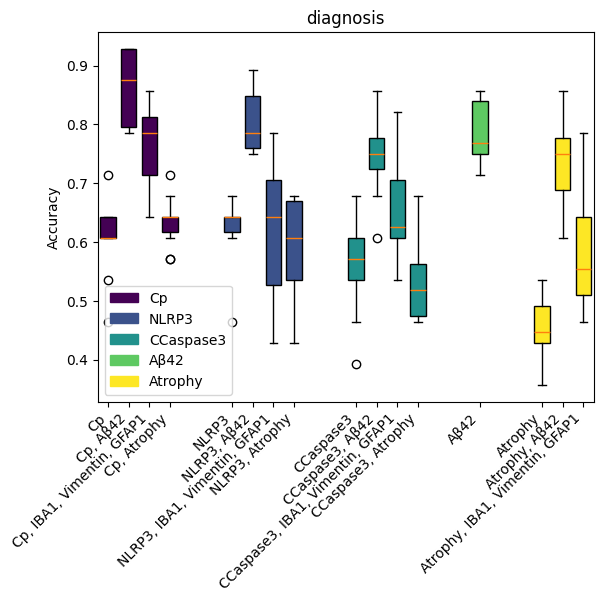

In [14]:
for bp in ["diagnosis"]:
    # Keep track of measures
    p_list = []
    label_list = []
    p_dict = dd(list)
    auc_dict = dd(list)
    auc_dict2 = dd(lambda: dd(list))
    p_dict_labels = dd(list)
    for i, ref_feat in enumerate(reference_features):
        for j, c_feat in enumerate(combined_features):
            if ref_feat == "Retinal Aβ42 total (12F4, %Area)":
                if j == 0:
                    feats = [ref_feat]
                else:
                    continue
            elif ref_feat in c_feat:
                if len(c_feat) == 1:
                    continue
                else:
                    raise ValueError(f"something wrong with c_feat; only expected one value: {c_feat}")
            else:
                feats = [ref_feat] + c_feat
            p, auc = retinad.analysis.cv_eval3(RandomForestClassifier, model_parameters, all_train, feats, bp)
            targets_to_keep.add(bp)
            label_list.append(", ".join([short_name[b] for b in feats]))
            p_list.append(p)
            p_dict[ref_feat].append(p)
            auc_dict[ref_feat].append(auc)
            auc_dict2[ref_feat][", ".join([short_name[b] for b in c_feat])].append(auc)
            p_dict_labels[ref_feat].append(", ".join([short_name[b] for b in feats]))

    # create plots
    cmap = plt.get_cmap('viridis')
    if len(p_list) > 0:
        lengths = []
        csum = [0]
        for k in p_dict.keys():
            lengths.append(len(p_dict[k]))
            csum.append(csum[-1] + lengths[-1])
        fig, bplot = plt.subplots(1)
        labels = []
        patch_list = []
        for idx, (k, p) in enumerate(p_dict.items()):
            b = bplot.boxplot(p, positions=csum[idx]+idx*2 + np.arange(lengths[idx]), widths=0.75, patch_artist=True)
            patch_list.append(mpatches.Patch(color=cmap(idx/(len(p_dict)-1)), label=short_name[k]))
            for patch in b["boxes"]:
                patch.set_facecolor(cmap(idx/(len(p_dict)-1)))

            labels += p_dict_labels[k]
            bplot.set_title(f"{bp}")
            bplot.set_ylabel("Accuracy")
            mmin = np.min(np.array(p_list))
        bplot.set_xticklabels(labels, rotation=45, ha="right")
        bplot.legend(handles=patch_list)

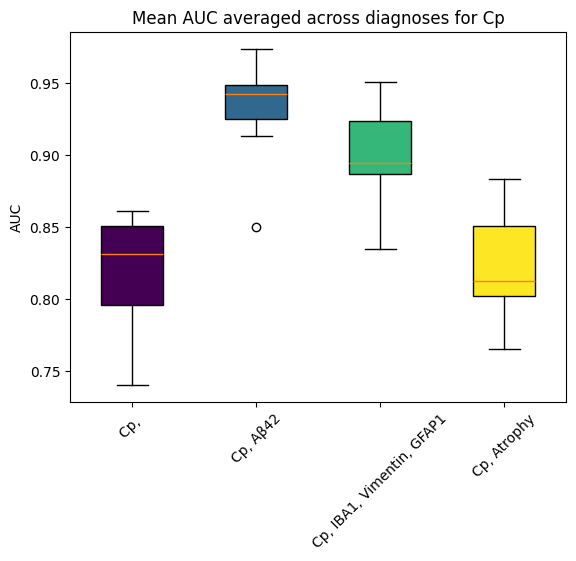

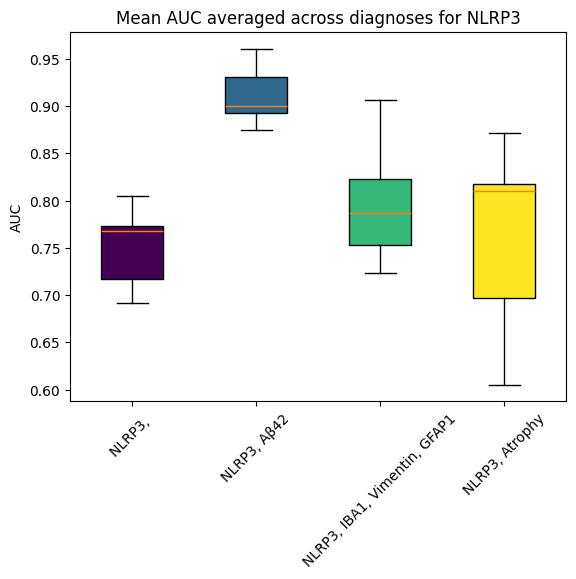

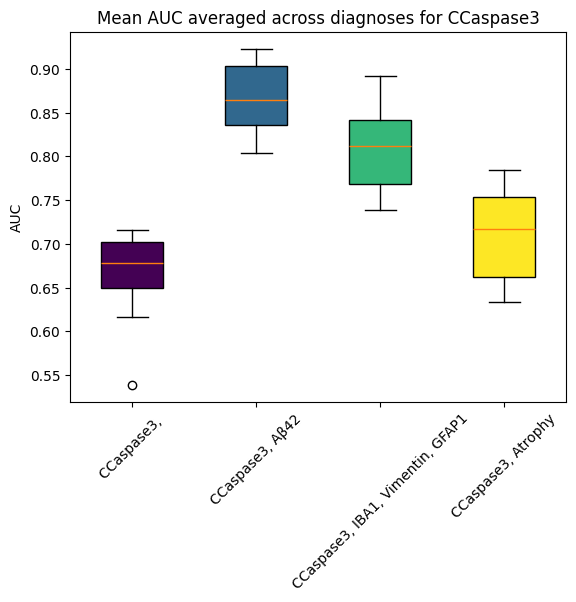

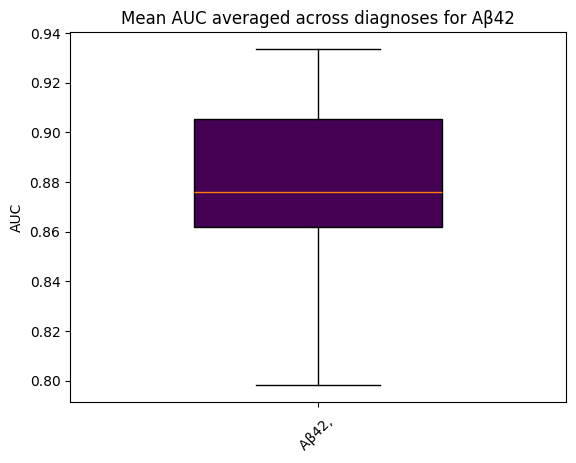

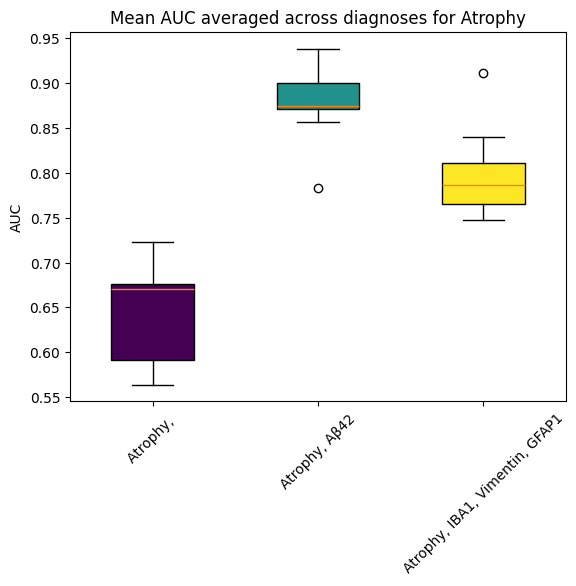

In [15]:
idx = 0  # for spacing in plot

for rfeat in auc_dict2.keys():
    fig, ax = plt.subplots(1)
    patch_list = []
    xtick_list = []
    for cfeat_idx, cfeat in enumerate(auc_dict2[rfeat].keys()):
        s = ", ".join([short_name[rfeat]] + [cfeat])
        if "Ret IBA1" in s and "Ret Vimentin" in s:
            s = short_name[ref_feat] + ", Ret Gliosis"
        try:
            patch_list.append(mpatches.Patch(color=cmap(cfeat_idx/(len(auc_dict2[rfeat])-1)), label=s))
        except ZeroDivisionError:
            patch_list.append(mpatches.Patch(color=cmap(cfeat_idx/(len(auc_dict2[rfeat]))), label=s))
        for i in ["all"]:
            b = ax.boxplot(auc_dict2[rfeat][cfeat][0][i], positions=[idx], patch_artist=True, widths=0.5)
            
            for ii, patch in enumerate(b["boxes"]):
                try:
                    patch.set_facecolor(cmap(cfeat_idx/(len(auc_dict2[rfeat])-1)))
                except ZeroDivisionError:
                    patch.set_facecolor(cmap(cfeat_idx/(len(auc_dict2[rfeat]))))
            idx += 1/4
        
        xtick_list += [s]
        idx = round(idx) + 1
    ax.set_xticklabels(xtick_list, rotation=45)
    ax.set_title(f"Mean AUC averaged across diagnoses for {short_name[rfeat]}")
    ax.set_ylabel("AUC")
    fig.savefig(f"{r_dir}/auc_all_dist_{short_name[rfeat].replace(' ','_')}.png", bbox_inches="tight")
    fig.savefig(f"{r_dir}/auc_all_dist_{short_name[rfeat].replace(' ','_')}.svg", bbox_inches="tight")
                       

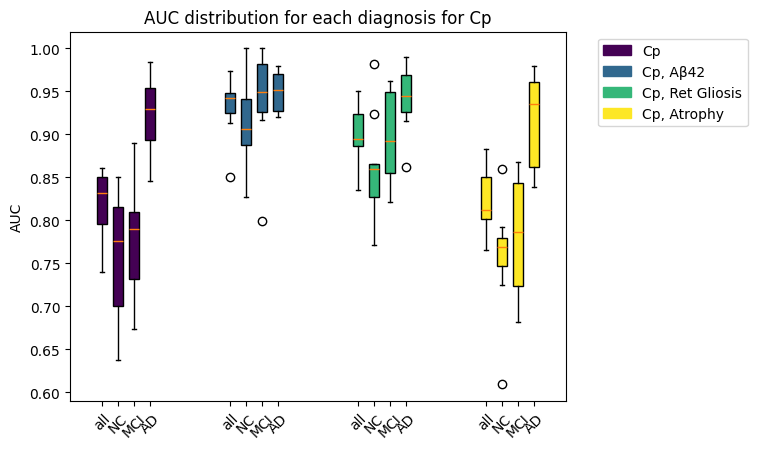

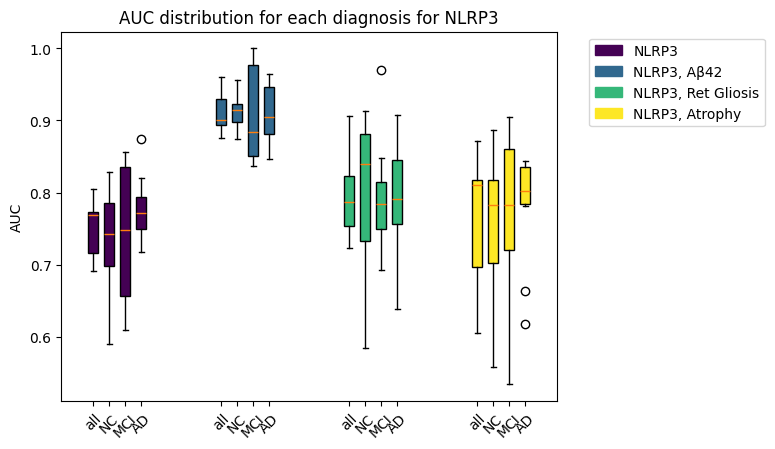

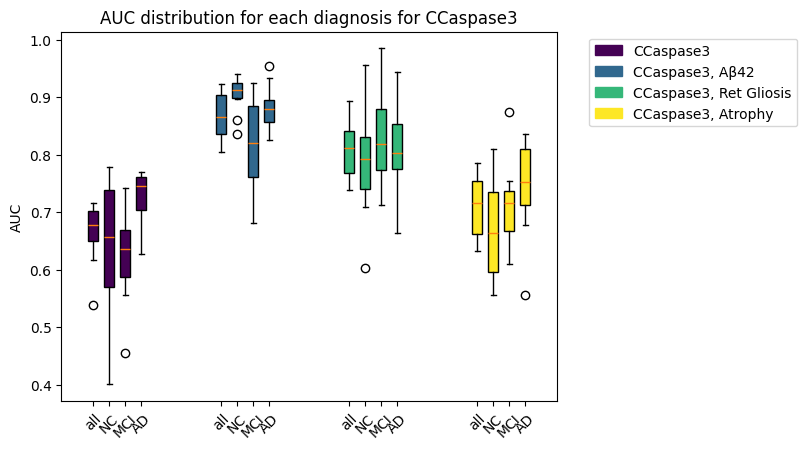

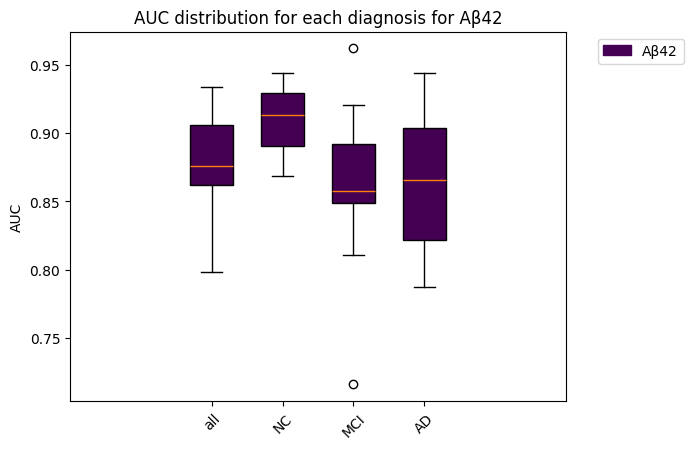

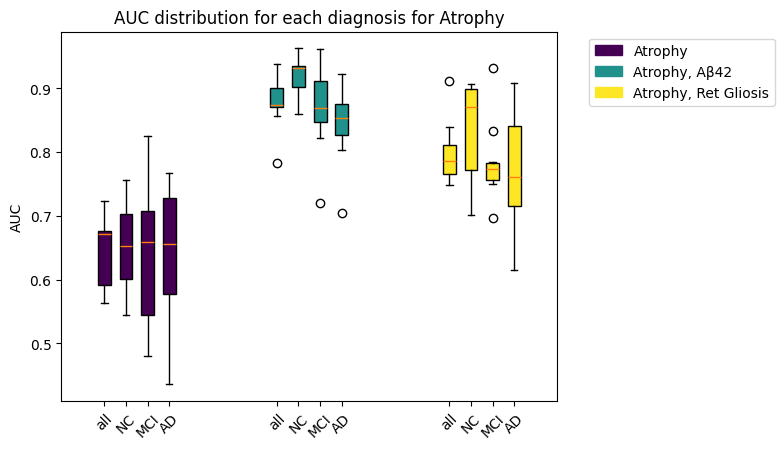

In [16]:
idx = 0

for rfeat in auc_dict2.keys():
    fig, ax = plt.subplots(1)
    patch_list = []
    xtick_list = []
    for cfeat_idx, cfeat in enumerate(auc_dict2[rfeat].keys()):
        s = ", ".join([short_name[rfeat]] + [cfeat])
        if s.endswith(","):
            s = s[:-1]
        elif s.endswith(", "):
            s = s[:-2]
        if "IBA1" in s and "Vimentin" in s:
            s = short_name[rfeat] + ", Ret Gliosis"
        try:
            patch_list.append(mpatches.Patch(color=cmap(cfeat_idx/(len(auc_dict2[rfeat])-1)), label=s))
        except ZeroDivisionError:
            patch_list.append(mpatches.Patch(color=cmap(cfeat_idx/(len(auc_dict2[rfeat]))), label=s))
        for i in ["all", "NC", "MCI", "AD"]:
            b = ax.boxplot(auc_dict2[rfeat][cfeat][0][i], positions=[idx], patch_artist=True)
            
            for ii, patch in enumerate(b["boxes"]):
                try:
                    patch.set_facecolor(cmap(cfeat_idx/(len(auc_dict2[rfeat])-1)))
                except ZeroDivisionError:
                    patch.set_facecolor(cmap(cfeat_idx/(len(auc_dict2[rfeat]))))
            idx += 1/4
        
        xtick_list += ["all", "NC", "MCI", "AD"]
        idx = round(idx) + 1
    ax.set_xticklabels(xtick_list, rotation=45)
    ax.set_title(f"AUC distribution for each diagnosis for {short_name[rfeat]}")
    ax.set_ylabel("AUC")
    ax.legend(handles=patch_list, bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.savefig(f"{r_dir}/auc_each_dist_{short_name[rfeat].replace(' ','_')}.png", bbox_inches="tight")
    fig.savefig(f"{r_dir}/auc_each_dist_{short_name[rfeat].replace(' ','_')}.svg", bbox_inches="tight")
                       

In [17]:
for bp in ["diagnosis"]:
    p_list = []
    label_list = []
    p_dict = dd(list)
    auc_dict = dd(list)
    auc_dict2 = dd(lambda: dd(list))
    roc_dicts = dd(list)
    roc_dict2 = dd(lambda: dd(list))
    p_dict_labels = dd(list)
    mean_tpr_dict = dd(lambda: dd(list))
    mean_auc_dict = dd(lambda: dd(list))
    pvals_dict = dd(lambda: dd(list))
    all_auc_dict = dd(lambda: dd(list))
    for i, ref_feat in enumerate(reference_features):
        for j, c_feat in enumerate(combined_features):
            print((i*len(combined_features) + j) / (len(reference_features)*len(combined_features)))
            feats = [ref_feat] + c_feat
            pval, mean_auc, mean_fpr, mean_tpr, all_auc = retinad.analysis.cv_eval6(RandomForestClassifier, model_parameters, all_train, feats, bp, n_clfs=1)

            targets_to_keep.add(bp)
            label_list.append(", ".join([short_name[b] for b in feats]))
            auc_dict2[ref_feat][", ".join([short_name[b] for b in c_feat])].append(mean_auc)
            p_dict_labels[ref_feat].append(", ".join([short_name[b] for b in feats]))
            mean_tpr_dict[ref_feat][", ".join([short_name[b] for b in c_feat])].append(mean_tpr)
            mean_auc_dict[ref_feat][", ".join([short_name[b] for b in c_feat])].append(mean_auc)
            pvals_dict[ref_feat][", ".join([short_name[b] for b in c_feat])].append(pval)
            all_auc_dict[ref_feat][", ".join([short_name[b] for b in c_feat])].append(all_auc)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [18]:
new_auc_dict = dd(lambda: dd(list))
for topfeat, cfeats_dict in all_auc_dict.items():
    for cfeat, label_dicts in cfeats_dict.items():
        new_auc_dict[topfeat][cfeat] = label_dicts[0]["NC"]
        continue

In [19]:
auc_dists_to_check = dict()
for topfeat, cfeats in new_auc_dict.items():
    for cfeat, aucs in cfeats.items():
        if ("Aβ42" in cfeat and "Aβ42" not in topfeat) or ("Aβ42" in topfeat and cfeat == ""):
            feat_str = ", ".join([short_name[topfeat], cfeat])
            auc_dists_to_check[feat_str] = aucs

In [20]:
import scipy.stats as stats
import itertools
def perform_wilcoxon_tests(feature_dict):
    p_vals = dd(lambda: dd(float))
    # Create all pairs of features
    feature_pairs = list(itertools.combinations(feature_dict.keys(), 2))
    for k0, v0 in feature_dict.items():
        for k1, v1 in feature_dict.items():
            if k0 == k1:
                p_vals[k0][k1] = 0
                continue
            feature1 = feature_dict[k0]
            feature2 = feature_dict[k1]

            # Perform the Wilcoxon rank test
            w, p = stats.wilcoxon(feature1, feature2)
            p_vals[k0][k1] = p
            print(f"Pair: {(k0, k1)}, W-statistic: {w}, p-value: {p}")
    return p_vals

In [21]:
wilcox_pvals = perform_wilcoxon_tests(auc_dists_to_check)

Pair: ('Cp, Aβ42', 'NLRP3, Aβ42'), W-statistic: 6.0, p-value: 0.02734375
Pair: ('Cp, Aβ42', 'CCaspase3, Aβ42'), W-statistic: 1.0, p-value: 0.00390625
Pair: ('Cp, Aβ42', 'Aβ42, '), W-statistic: 0.0, p-value: 0.001953125
Pair: ('Cp, Aβ42', 'Atrophy, Aβ42'), W-statistic: 0.0, p-value: 0.001953125
Pair: ('NLRP3, Aβ42', 'Cp, Aβ42'), W-statistic: 6.0, p-value: 0.02734375
Pair: ('NLRP3, Aβ42', 'CCaspase3, Aβ42'), W-statistic: 0.0, p-value: 0.001953125
Pair: ('NLRP3, Aβ42', 'Aβ42, '), W-statistic: 0.0, p-value: 0.001953125
Pair: ('NLRP3, Aβ42', 'Atrophy, Aβ42'), W-statistic: 0.0, p-value: 0.001953125
Pair: ('CCaspase3, Aβ42', 'Cp, Aβ42'), W-statistic: 1.0, p-value: 0.00390625
Pair: ('CCaspase3, Aβ42', 'NLRP3, Aβ42'), W-statistic: 0.0, p-value: 0.001953125
Pair: ('CCaspase3, Aβ42', 'Aβ42, '), W-statistic: 24.0, p-value: 0.76953125
Pair: ('CCaspase3, Aβ42', 'Atrophy, Aβ42'), W-statistic: 15.0, p-value: 0.232421875
Pair: ('Aβ42, ', 'Cp, Aβ42'), W-statistic: 0.0, p-value: 0.001953125
Pair: ('Aβ42,

In [22]:
# Create matrix for plotting
matrix = np.zeros((len(wilcox_pvals.keys()), len(wilcox_pvals.keys())))
i_list = []
j_list = []

r = 0
for i, feature1 in enumerate(wilcox_pvals.keys()):
    if feature1 not in i_list:
        i_list.append(feature1)
    for j, feature2 in enumerate(wilcox_pvals.keys()):
        if feature2 not in j_list:
            j_list.append(feature2)
        if feature1 == feature2:
            matrix[i, j] = 0.0
        else:
            # get p-value from results
            p_value = wilcox_pvals[feature1][feature2]
            matrix[i, j] = p_value

/tmp/ipykernel_83896/1311252543.py:2: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(-np.log10(matrix))


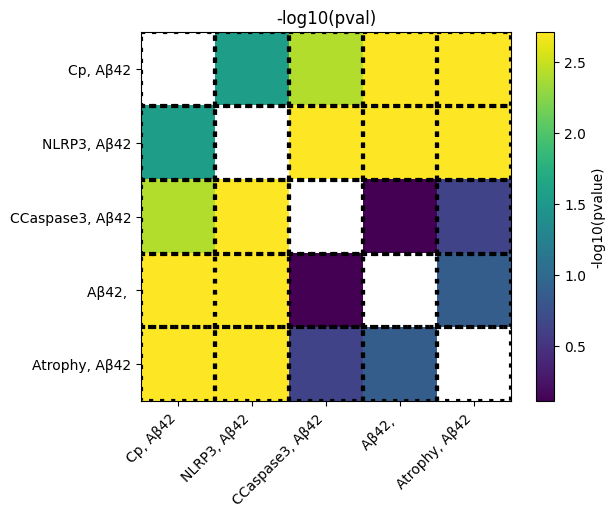

In [23]:
fig, ax = plt.subplots(1)
im = ax.imshow(-np.log10(matrix))
ax.set_xticks(np.arange(matrix.shape[0]))
ax.set_xticklabels(i_list, rotation=45, ha="right")
ax.set_yticks(np.arange(matrix.shape[1]))
ax.set_yticklabels(i_list)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("-log10(pvalue)")
ax.set_title("-log10(pval)")
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.add_patch(Rectangle((i-0.5, j-0.5), 1, 1, fill=False, edgecolor='black', lw=3, linestyle=":"))
plt.savefig(f"{r_dir}/logpvalues_uncorrected.png", bbox_inches="tight")
plt.savefig(f"{r_dir}/logpvalues_uncorrected.svg", bbox_inches="tight")

In [24]:
# For displaying '42' as an underscore
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

i_list2 = []
for i in i_list:
    i = i.replace("Ret ", "")
    i = i.replace("Ret", "")
    i = i.rstrip()
    if i.endswith(","):
        i = i[:-1]
    
    if "42" in i:
        i = "$" + i.replace("42", "_{42}") + "$"

    i_list2.append(i)
i_list2

['$Cp, Aβ_{42}$',
 '$NLRP3, Aβ_{42}$',
 '$CCaspase3, Aβ_{42}$',
 '$Aβ_{42}$',
 '$Atrophy, Aβ_{42}$']

/tmp/ipykernel_83896/3177758456.py:23: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(-np.log10(p_values_corrected_matrix))


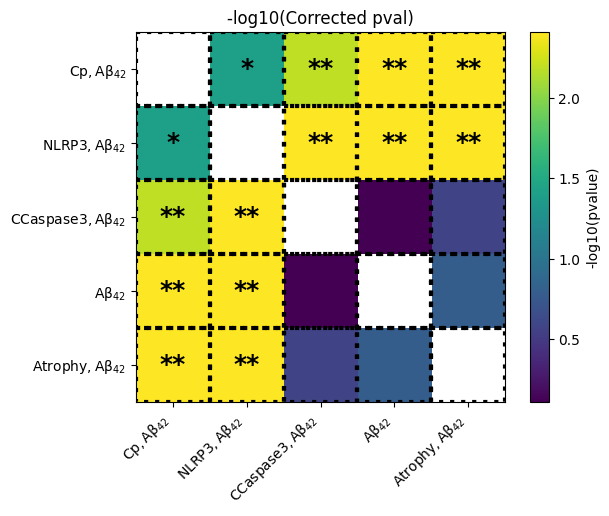

In [25]:
from statsmodels.sandbox.stats.multicomp import multipletests

lin_pvals = []
ij = []
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        p = matrix[i,j]
        if p > 0:
            ij.append((i,j))
            lin_pvals.append(p)

# Apply the Benjamini-Hochberg procedure
p_values_corrected = multipletests(lin_pvals, method='fdr_bh')[1]
# Now 'p_values_corrected' is an array of corrected p-values.

p_values_corrected_matrix = np.zeros(matrix.shape)
for i, pval in enumerate(p_values_corrected):
    p_values_corrected_matrix[ij[i][0], ij[i][1]] = pval



fig, ax = plt.subplots(1)
im = ax.imshow(-np.log10(p_values_corrected_matrix))
ax.set_xticks(np.arange(p_values_corrected_matrix.shape[0]))
ax.set_xticklabels(i_list2, rotation=45, ha="right")
ax.set_yticks(np.arange(p_values_corrected_matrix.shape[1]))
ax.set_yticklabels(i_list2)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("-log10(pvalue)")
ax.set_title("-log10(Corrected pval)")
for i in range(p_values_corrected_matrix.shape[0]):
    for j in range(p_values_corrected_matrix.shape[1]):
        ax.add_patch(Rectangle((i-0.5, j-0.5), 1, 1, fill=False, edgecolor='black', lw=3, linestyle=":"))
for i in range(p_values_corrected_matrix.shape[0]):
    for j in range(p_values_corrected_matrix.shape[1]):
        if i == j:
            continue
        s = ""
        p = p_values_corrected_matrix[i,j]
        if p < 0.05:
            s = "*"
        if p < 0.01:
            s = "**"
        if p < 0.001:
            s = "***"
        if p < 0.0001:
            s = "****"
        ax.text(i,j, s, fontsize=18, ha='center', va='center', weight='bold')
plt.savefig(f"{r_dir}/logpvalues_corrected.png", bbox_inches="tight")
plt.savefig(f"{r_dir}/logpvalues_corrected.svg", bbox_inches="tight")

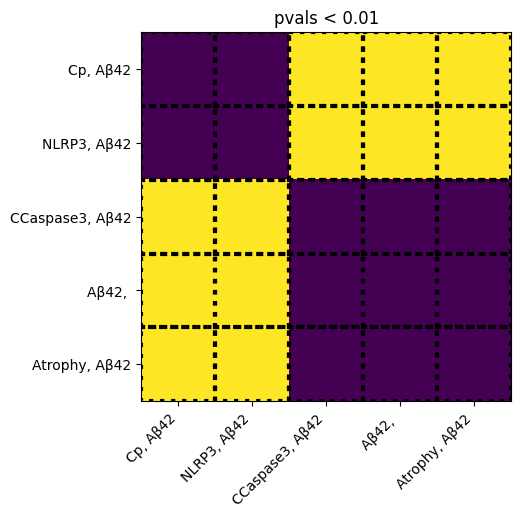

In [26]:
fig, ax = plt.subplots(1)
im = ax.imshow((matrix < 0.01) - np.eye(matrix.shape[0]))
ax.set_xticks(np.arange(matrix.shape[0]))
ax.set_xticklabels(i_list, rotation=45, ha="right")
ax.set_yticks(np.arange(matrix.shape[1]))
ax.set_yticklabels(i_list)
ax.set_title("pvals < 0.01")
for i in range(p_values_corrected_matrix.shape[0]):
    for j in range(p_values_corrected_matrix.shape[1]):
        ax.add_patch(Rectangle((i-0.5, j-0.5), 1, 1, fill=False, edgecolor='black', lw=3, linestyle=":"))
fig.savefig(f"{r_dir}/pval_lessthan_0_01_uncorrected.png", bbox_inches="tight")
fig.savefig(f"{r_dir}/pval_lessthan_0_01_uncorrected.svg", bbox_inches="tight")

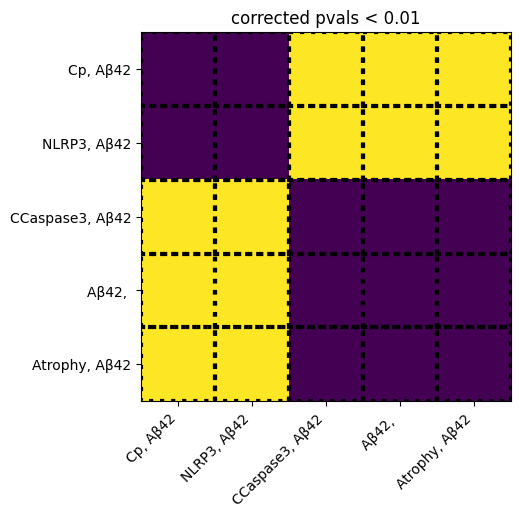

In [27]:
fig, ax = plt.subplots(1)
im = ax.imshow((p_values_corrected_matrix < 0.01) - np.eye(p_values_corrected_matrix.shape[0]))
# im = ax.imshow((p_values_corrected_matrix + p_values_corrected_matrix.T) < 0.01)
ax.set_xticks(np.arange(p_values_corrected_matrix.shape[0]))
ax.set_xticklabels(i_list, rotation=45, ha="right")
ax.set_yticks(np.arange(p_values_corrected_matrix.shape[1]))
ax.set_yticklabels(i_list)
ax.set_title("corrected pvals < 0.01")

from matplotlib.patches import Rectangle

for i in range(p_values_corrected_matrix.shape[0]):
    for j in range(p_values_corrected_matrix.shape[1]):
        ax.add_patch(Rectangle((i-0.5, j-0.5), 1, 1, fill=False, edgecolor='black', lw=3, linestyle=":"))
fig.savefig(f"{r_dir}/pval_lessthan_0_01_corrected.png", bbox_inches="tight")
fig.savefig(f"{r_dir}/pval_lessthan_0_01_corrected.svg", bbox_inches="tight")

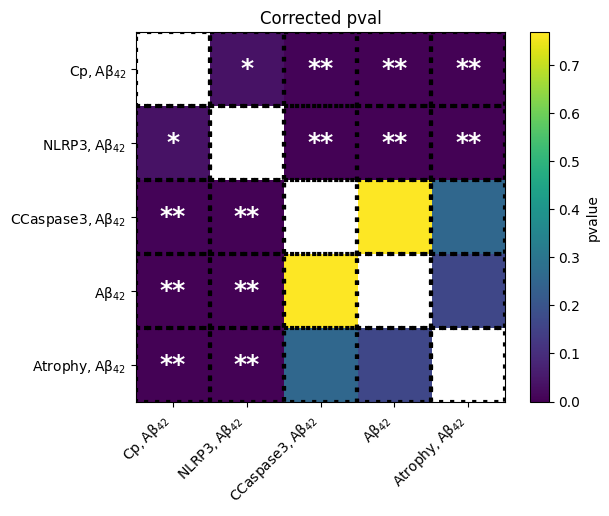

In [28]:
from statsmodels.sandbox.stats.multicomp import multipletests

lin_pvals = []
ij = []
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        p = matrix[i,j]
        if p > 0:
            ij.append((i,j))
            lin_pvals.append(p)

# Apply the Benjamini-Hochberg procedure
p_values_corrected = multipletests(lin_pvals, method='fdr_bh')[1]
# Now 'p_values_corrected' is an array of corrected p-values. 

p_values_corrected_matrix = np.zeros(matrix.shape)
for i, pval in enumerate(p_values_corrected):
    p_values_corrected_matrix[ij[i][0], ij[i][1]] = pval

            

fig, ax = plt.subplots(1)
buf = p_values_corrected_matrix
for i in range(buf.shape[0]):
    buf[i,i] = np.nan
im = ax.imshow(buf, vmin=0)
ax.set_xticks(np.arange(p_values_corrected_matrix.shape[0]))
ax.set_xticklabels(i_list2, rotation=45, ha="right")
ax.set_yticks(np.arange(p_values_corrected_matrix.shape[1]))
ax.set_yticklabels(i_list2)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("pvalue")
ax.set_title("Corrected pval")
for i in range(p_values_corrected_matrix.shape[0]):
    for j in range(p_values_corrected_matrix.shape[1]):
        ax.add_patch(Rectangle((i-0.5, j-0.5), 1, 1, fill=False, edgecolor='black', lw=3, linestyle=":"))
for i in range(p_values_corrected_matrix.shape[0]):
    for j in range(p_values_corrected_matrix.shape[1]):
        if i == j:
            continue
        s = ""
        p = p_values_corrected_matrix[i,j]
        if p < 0.05:
            s = "*"
        if p < 0.01:
            s = "**"
        if p < 0.001:
            s = "***"
        if p < 0.0001:
            s = "****"
        ax.text(i,j, s, fontsize=18, ha='center', va='center', weight='bold', color="white")
plt.savefig(f"{r_dir}/pvalues_corrected.png", bbox_inches="tight")
plt.savefig(f"{r_dir}/pvalues_corrected.svg", bbox_inches="tight")

In [29]:
np.savetxt(f"{r_dir}/uncorrected_pvals.txt", matrix, fmt="%f")
np.savetxt(f"{r_dir}/corrected_pvals.txt", p_values_corrected_matrix, fmt="%f")

In [30]:
for i, ref_feat in enumerate(reference_features):
    for j, c_feat in enumerate(combined_features):
        print((i*len(combined_features) + j) / (len(reference_features)*len(combined_features)))
        feats = [ref_feat] + c_feat
        pval, mean_auc, mean_fpr, mean_tpr, all_auc = retinad.analysis.cv_eval6(RandomForestClassifier, model_parameters, all_train, feats, bp, n_clfs=1)
        

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [31]:
r = RandomForestClassifier(n_estimators=80, random_state=0)
r.fit(all_train[["Retinal Aβ42 total (12F4, %Area)","Retinal Cp (% area)"]], all_train["diagnosis"])

RandomForestClassifier(n_estimators=80, random_state=0)

In [32]:
## Keys previously used "Ret AB42"; switching to just "AB42"
# keys = {}
# keys['Retinal Cp (% area)'] = [""]
# keys['Retinal Aβ42 total (12F4, %Area)'] = [""]
# keys['Retinal NLRP3 (% area)'] = [""]
# keys['Retinal Cleaved Caspase-3 (% area)'] = [""]
# keys['Retinal Atrophy (severity score)'] = [""]
# keys['Retinal Cp (% area)'] += ['Ret Aβ42']
# keys['Retinal NLRP3 (% area)'] += ['Ret Aβ42']
# keys['Retinal Cleaved Caspase-3 (% area)'] += ['Ret Aβ42']
# keys['Retinal Atrophy (severity score)'] += ['Ret Aβ42']

keys = {}
keys['Retinal Cp (% area)'] = [""]
keys['Retinal Aβ42 total (12F4, %Area)'] = [""]
keys['Retinal NLRP3 (% area)'] = [""]
keys['Retinal Cleaved Caspase-3 (% area)'] = [""]
keys['Retinal Atrophy (severity score)'] = [""]
keys['Retinal Cp (% area)'] += ['Aβ42']
keys['Retinal NLRP3 (% area)'] += ['Aβ42']
keys['Retinal Cleaved Caspase-3 (% area)'] += ['Aβ42']
keys['Retinal Atrophy (severity score)'] += ['Aβ42']

In [33]:
import math
def round_to_significant(num, sig_figs):
    """Round a number to a specific number of significant figures."""
    if num == 0:
        return 0
    return round(num, -int(math.floor(math.log10(abs(num)))) + (sig_figs - 1))


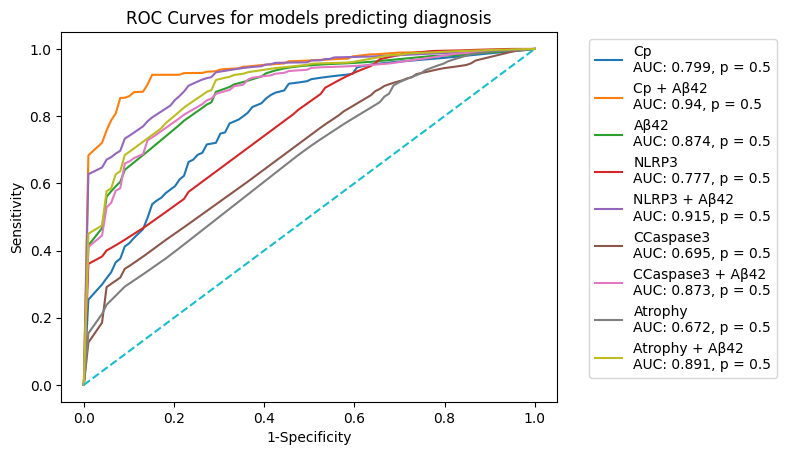

In [34]:
for k, v in keys.items():
    for sub in v:
        auc = mean_auc_dict[k][sub][0]
        p = np.mean(pvals_dict[k][sub])
        if p < 0.0001:
            p_string = "p < 0.0001"
        elif p < 0.001:
            p_string = "p < 0.001"
        elif p < 0.01:
            p_string = "p < 0.01"
        else:
            p_string = f"p = {round_to_significant(p, 3)}"
            
        if sub != "":
            label=f"{short_name[k]} + {sub}"
        else:
            label=f"{short_name[k]}"
        label = "\n".join([label, f"AUC: {round(auc,3)}, {p_string}"])
        plt.plot(mean_fpr, np.squeeze(mean_tpr_dict[k][sub]), label=label)
plt.plot([0,1],[0,1], "--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("ROC Curves for models predicting diagnosis")
plt.savefig(f"{r_dir}/roc_curves.png", bbox_inches="tight")
plt.savefig(f"{r_dir}/roc_curves.svg", bbox_inches="tight")

# Final evaluation

In [35]:
import sklearn

In [36]:
retinal_features

['Retinal Cp (% area)',
 'Retinal Aβ42 total (12F4, %Area)',
 'Retinal AβOi total  μm2x103',
 'Retinal GFAP1 % area Bhakta',
 'Retinal IBA1 % area Bhakta',
 'Retinal Atrophy (severity score)',
 'Retinal Vimentin total area/1000 (μm2x103)',
 'Retinal Nissl  (% area) ONL+INL+GCL',
 'Retinal MC-1 tau (% area)',
 'Retinal Oligo-tau T22 (% area)',
 'Retinal pS396 (% area)',
 'Retinal PHF-1 (% area)',
 'Retinal NLRP3 (% area)',
 'Retinal Caspase-1 (% area)',
 'Retinal ASC (% area)',
 'Retinal Cleaved Caspase-3 (% area)',
 'Retinal NGSDMD (% area)',
 'Retinal vAβ40 all Vessels ( 11A50-B10 % area)',
 'PDGFRβ All quadrants (All vessels % area) ',
 'Aβ40 Total (All regions μm2x103) ']

In [37]:
final_features = ['Retinal Cp (% area)', 'Retinal Aβ42 total (12F4, %Area)']
final_target = "diagnosis"
r = RandomForestClassifier(n_estimators=80, random_state=0)
r.fit(all_train[final_features], all_train[final_target])

RandomForestClassifier(n_estimators=80, random_state=0)

In [38]:
r.score(test[final_features], test[final_target])

0.7142857142857143

In [39]:
final_predictions = r.predict_proba(test[final_features])

possible_targets = list(np.unique(test[final_target]))
possible_targets.sort(reverse=True)
fpr = dict()
tpr = dict()
for t in possible_targets:
    label_idx = list(r.classes_).index(t)
    fpr[t], tpr[t], _ = sklearn.metrics.roc_curve(test[final_target] == t, final_predictions[:, label_idx])
    

In [40]:
sklearn.metrics.roc_auc_score(test[final_target], final_predictions, multi_class="ovr", average="macro")

np.float64(0.9072356215213357)

In [41]:
final_class_pred = r.predict(test[final_features])
sklearn.metrics.recall_score(test[final_target], final_class_pred, average="macro")

np.float64(0.6825396825396824)

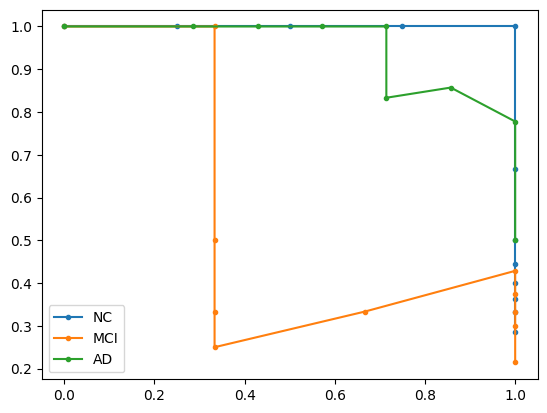

In [42]:
# Not enough data in the test set for this plot to be meaningful
for target in possible_targets:
    label_idx = list(r.classes_).index(target)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(test[final_target] == target, final_predictions[:, label_idx])
    plt.plot(recall, precision, ".-", label=target)
plt.legend()

In [43]:
for target in possible_targets:
    label_idx = list(r.classes_).index(target)
    print(target)
    print(label_idx)
    print(sklearn.metrics.roc_auc_score(test[final_target] == target, final_predictions[:, label_idx], multi_class="ovr", average="macro"))

NC
2
1.0
MCI
1
0.7727272727272727
AD
0
0.9489795918367347


In [44]:
cm = sklearn.metrics.confusion_matrix(test[final_target], final_class_pred)

In [45]:
r.classes_

array(['AD', 'MCI', 'NC'], dtype=object)

/tmp/ipykernel_83896/481978176.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(r.classes_))
/tmp/ipykernel_83896/481978176.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(r.classes_))


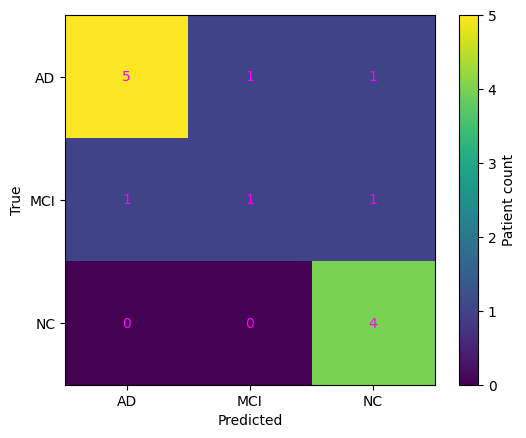

In [46]:
fig, ax = plt.subplots()
cax = ax.matshow(cm)
ax.set_xticklabels([''] + list(r.classes_))
ax.set_yticklabels([''] + list(r.classes_))
cbar = fig.colorbar(cax)
cbar.set_label("Patient count")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='magenta')
ax.xaxis.tick_bottom()
fig.savefig(f"{r_dir}/test_confusion_matrix.png")
fig.savefig(f"{r_dir}/test_confusion_matrix.svg")